# Fully Reparameterized Variational Sequential Monte Carlo
Julia Notebook

Project GitHub: https://github.com/chiukenny/STAT520B-finalproject

Note: some VSMC code is adapted from https://github.com/blei-lab/variational-smc

Note: the number of iterations, runs, and samples have been lowered in this notebook so that the entire notebook can be run in a few minutes. These settings can be found under each experiment section that starts with "Experiment #" (e.g., Experiment 1)

In [1]:
# If true, running this notebook will save figures in the same directory
save_figures = false

false

In [2]:
using Random, LinearAlgebra, Distributions, Plots, LaTeXStrings, RDatasets

# AutoGrad is used due to being able to "ignore" the gradients of specific functions
using AutoGrad, ForwardDiff

# Adam optimizer
using HTTP: request
"https://gist.githubusercontent.com/vankesteren/96207abcd16ecd01a2491bcbec12c73f/raw/1b59af6962a1107db5873eba59054acc3f9a8aac/Adamopt.jl" |>
    url -> request("GET", url) |> 
    res -> String(res.body) |> 
    str -> include_string(Main, str)
using .Adamopt

# 1. Shared functions and code

### 1.1. Constants and global parameters

In [3]:
# Method ids
VSMC = "VSMC"
uVSMC = "uVSMC"
GS_VSMC = "GS-VSMC"
IGR_VSMC = "IGR-VSMC"

# Step functions
RHO = "rho"
ADAM = "adam"

# Method colors for plotting
VSMC_col = :blue
uVSMC_col = :purple
GS_VSMC_col = :red
IGR_VSMC_col = :green

# Plotting parameters
LW_LO_FA = (linewidth=2, lineopacity=0.7, fillalpha=0.15)

# Initialize PyPlot
pyplot(size=(770,200))

Plots.PyPlotBackend()

### 1.2. Sequential Monte Carlo and distribution related

In [4]:
# "Class" for encapsulating items needed for SMC
mutable struct SMC
    dimX::Integer  # Dimension of latent variables
    dimY::Integer  # Dimension of observations
    T::Integer     # Length of sequence
    N::Integer     # Number of particles
    
    sim_prop       # Function for sampling from proposal
    log_weights    # Function for computing log weights
    log_prop       # Function for computing log proposal
end


# Computes the log marginal likelihood of a (S)LGSS using the Kalman filter
function log_marginal_likelihood(model_params, T, y, dimX)
    # output: log marginal likelihood of y
    μ0, Σ0, A, Q, C, R = model_params
    
    # Initialize Kalman filter
    log_likelihood = 0
    x_filt = zeros(dimX)
    P_filt = zeros(dimX, dimX)
    x_pred = μ0
    P_pred = Σ0
    
    for t in 1:T
        if t > 1
            # Predict step
            x_pred = A * x_filt
            P_pred = A*P_filt*A' + Q
        end
        
        # Update step
        yt = y[t,:] .- C*x_pred
        S = C*P_pred*C' + R
        K = (S \ (C*P_pred))'
        x_filt = x_pred .+ K*yt
        P_filt = P_pred - K*C*P_pred
        
        log_likelihood += -0.5*(dot(yt,S\yt) + logdet(S) + log(2*π))
    end
    return log_likelihood
end


# Computes the log probability of a uni/multivariate normal
function log_normal(x, μ, Σ)
    # x: value(s) to evaluate
    # μ: mean(s) 
    # Σ: covariance matrix
    # output: log likelihood(s)
    dim = size(x)[2]
    log_norm = -0.5*dim*log(2*π) - 0.5*logdet(Σ)
    
    # There may be multiple x to evaluate, possibly each with its own mean
    if size(x) == size(μ)
        diff = x - μ
    else
        diff = x .- μ'
    end
    
    prec = inv(Σ) # AutoGrad does not support \ operator with two matrices
    return log_norm .- 0.5*diag(diff*prec*diff') # Original code does sum here but that seems incorrect
end


# Computes the log probability of the joint model in (S)LGSS
function log_target(t, X, X_anc, y, model_params)
    # X: proposal states
    # X_anc: ancestor states
    # output: log probability of the target
    μ0, Σ0, A, Q, C, R = model_params
    log_trans = log_normal(X, (A*X_anc')', Q) # Proposal log probability
    log_obs = log_normal((C*X')', y[t] ,R)    # Emission log probability
    return log_trans + log_obs
end

log_target (generic function with 1 method)

### 1.3. Variational Sequential Monte Carlo related

In [5]:
# Categorical resampling procedure
function categorical_resample(W)
    # output: N indices in {1,...,N}
    N = size(W)[1]
    dist = Categorical(W[:,1])
    return rand(dist,N)
end
# Ignore the gradient of this function when using AutoGrad
@zerograd categorical_resample(W)


# Gumbel-Softmax resampling procedure
function gumbelsoftmax_resample(W, X, τ)
    # X: ancestor states to mix
    # output: [N,dimX] matrix of mixed ancestor states
    N = size(W)[1]
    
    # Sample from Gumbel(0,1) by transforming Unif(0,1) samples
    g = -log.(-log.(rand(N,N)))
    
    # Compute softmax
    z = (log.(W') .+ g) ./ τ
    max_z = maximum(z, dims=2)
    anc = exp.(z .- max_z)
    anc = anc ./ sum(anc,dims=2)
    
    # Return N mixed states
    return anc * X
end


# Invertible Gaussian Reparameterization sampling procedure
function invertgaussian_resample(W, X, τ; δ=1, iters=25, n=100)
    # X: ancestor states to mix
    # δ: positive real
    # iters: number of SGD iterations
    # n: number of samples to estimate expectation
    # output: [N,dimX] matrix of mixed ancestor states
    N = size(W)[1]
    
    # Optimize parameters to approximate Categorical(W)
    p = zeros(2*(N-1))
    
    # Objective to optimize
    function exp_sq_norm_diff(p)
        # Extract parameters
        μ = p[1:N-1]
        σ = exp.(p[N:(2*(N-1))])
        
        # Compute 100 samples
        z = (μ' .+ σ' .* randn(n,N-1)) ./ τ
        
        # Compute softmax
        max_z = maximum(z, dims=2)
        anc = exp.(z .- max_z)
        anc = anc ./ (sum(anc,dims=2) .+ δ .* exp.(-max_z))
        
        # Estimate the expectation of the squared norm of the difference
        anc = [anc (1 .- sum(anc,dims=2))]
        return sum((mean(anc,dims=1) .- W').^2)
    end
    
    # Optimize IGR parameters using SGD
    step_f = i -> 1/sqrt(i)
    for i in 1:iters
        gradcost = ForwardDiff.gradient(p->exp_sq_norm_diff(p), p)
        p = p .- step_f(i) .* gradcost
    end
    
    # Extract learned parameters
    μ = p[1:N-1]
    σ = exp.(p[N:(2*(N-1))])
    
    # Sample Gaussian noise
    z = (μ' .+ σ' .* randn(N,N-1)) ./ τ
    
    # Compute softmax
    max_z = maximum(z, dims=2)
    anc = exp.(z .- max_z)
    anc = anc ./ (sum(anc,dims=2) .+ δ .* exp.(-max_z))
    anc = [anc (1 .- sum(anc,dims=2))]
    
    # Return N mixed states
    return anc * X
end


# Estimates the VSMC lower bound by running SMC
function vsmc_lower_bound(prop_params, model_params, y, smc; method=VSMC, τ=0.05, return_ess=false)
    # smc: SMC struct object
    # method: one of {VSMC, uVSMC, GS_VSMC, IGR_VSMC}
    # return_ess: if true, returns ESS as second output
    # output: log p(y_1:T), ESS (if return_ess==true)
    @assert method==VSMC || method==uVSMC || method==GS_VSMC || method==IGR_VSMC
    
    # Extract SMC parameters
    T = smc.T
    dimX = smc.dimX
    N = smc.N
    
    # Initialize SMC
    X = zeros(N, dimX)
    X_anc = zeros(N, dimX)
    logW = zeros(N)
    W = exp.(logW) ./ N
    logZ = 0
    
    # Run SMC
    for t in 1:T
        # Resample step
        if t > 1
            if method == GS_VSMC
                X_anc = gumbelsoftmax_resample(W,X,τ)
            elseif method == IGR_VSMC
                X_anc = invertgaussian_resample(W,X,τ)
            else
                anc = categorical_resample(W)
                X_anc = X[anc,:]
            end
        end
        
        # Propose step
        X = smc.sim_prop(t, X_anc, y, prop_params, model_params)
        
        # Reweight step
        logW = smc.log_weights(t, X, X_anc, y, prop_params, model_params)
        max_logW = max(logW...)
        W = exp.(logW .- max_logW)
        
        # Update normalization constant before normalizing weights
        logZ = logZ + max_logW + log(sum(W)) - log(N)
        W /= sum(W)
    end
    
    if return_ess
        # Compute effective sample size divided by N
        ess = (1/sum(W.^2)) / N
        return logZ, ess
    else
        return logZ
    end
end


# Computes the unbiased gradient estimator grep + gscore for Categorical VSMC
# using the definition given in Appendix A.3 of Naesseth et al. (2018)
function ∇vsmc_lower_bound(flat_params, model_params, y, smc; unflatten_f=nothing)
    # smc: SMC struct object
    # unflatten_f: function to unflatten parameters if more than one parameter
    # output: grep + gscore
    
    # Reshape parameters if more than one
    if isnothing(unflatten_f)
        unflatten_f = flat_params -> flat_params
        prop_params = flat_params
    else
        prop_params = unflatten_f(flat_params)
    end
    
    # Extract SMC parameters and constants
    T = smc.T
    dimX = smc.dimX
    N = smc.N
    dimλ = length(flat_params)
    
    # Initialize SMC
    X = zeros(N, dimX)
    X_anc = zeros(N, dimX)
    logW = zeros(N)
    W = exp.(logW) / N
    logZs = zeros(T)
    anc = 1:N
    
    # Initialize quantities needed for computing grep and gscore
    prev_∇log_W = zeros(N, dimλ)
    ∇logϕ = zeros(dimλ)
    grep = zeros(dimλ)
    
    # Run SMC
    for t in 1:T
        # Resample step
        if t > 1
            anc = categorical_resample(W)
            X_anc = X[anc,:]
        end
        
        # Propose step
        X = smc.sim_prop(t, X_anc, y, prop_params, model_params)
        
        # Closure of log_prop function for AutoGrad
        function log_prop(flat_params, i)
            prop_params = unflatten_f(flat_params)
            return smc.log_prop(t, X, X_anc, y, prop_params, model_params)[i]
        end
        ∇log_prop = grad(log_prop)
        
        # Compute log proposal and log ancestor weight portion of ∇logϕ
        for i in 1:N
            ∇logϕ += ∇log_prop(flat_params,i) + prev_∇log_W[anc[i],:]
        end
        
        # Reweight step
        logW = smc.log_weights(t, X, X_anc, y, prop_params, model_params)
        max_logW = max(logW...)
        W = exp.(logW .- max_logW)
        
        # Update normalization constant before normalizing weights
        if t > 1
            logZs[t] = logZs[t-1] + max_logW + log(sum(W)) - log(N)
        else
            logZs[t] = max_logW + log(sum(W)) - log(N)
        end
        W /= sum(W)
        
        # Closure of log_weights function for AutoGrad
        function log_weights(flat_params, i)
            prop_params = unflatten_f(flat_params)
            return smc.log_weights(t, X, X_anc, y, prop_params, model_params)[i]
        end
        ∇log_weights = grad(log_weights)
        
        # Compute ∇logW for both grep and gscore
        for i in 1:N
            prev_∇log_W[i,:] = ∇log_weights(flat_params,i)
            grep += W[i] .* prev_∇log_W[i,:]
        end
        
        # Compute updated weight portion of ∇logϕ
        if t < T
            ∇logϕ -= N .* (prev_∇log_W' * W)
        end
    end
    
    g_score = logZs[T] .* ∇logϕ
    return grep + g_score
end


# Samples a sequence x_1:T from VSMC
function sim_q(prop_params, model_params, y, smc; method=VSMC, τ=0.05)
    # smc: SMC struct object
    # method: one of {VSMC, uVSMC, GS_VSMC, IGR_VSMC}
    # output: state sequence of length T (note: may be in form of a [1,T,1] matrix)
    @assert method==VSMC || method==uVSMC || method==GS_VSMC || method==IGR_VSMC
    
    # Extract SMC parameters
    T = smc.T
    dimX = smc.dimX
    N = smc.N
    
    # Initialize SMC
    X = zeros(N, dimX)
    X_anc = zeros(N, T, dimX)
    logW = zeros(N)
    W = exp.(logW) ./ N
    
    # Run SMC
    for t in 1:T
        # Resample step
        if t > 1
            if method == GS_VSMC
                X_anc[:,t,:] = gumbelsoftmax_resample(W,X,τ)
            elseif method == IGR_VSMC
                X_anc[:,t,:] = invertgaussian_resample(W,X,τ)
            else
                anc = categorical_resample(W)
                X_anc[:,t,:] = X[anc,:]
            end
        end
        
        # Propose step
        X = smc.sim_prop(t, X_anc[:,t,:], y, prop_params, model_params)
        
        # Reweight step
        logW = smc.log_weights(t, X, X_anc[:,t,:], y, prop_params, model_params)
        max_logW = max(logW...)
        W = exp.(logW .- max_logW)
        W /= sum(W)
    end
    
    # Sample from empirical approximation
    dist = Categorical(W)
    b = rand(dist,1)
    return X_anc[b,:,:]
end

sim_q (generic function with 1 method)

### 1.4. Gradient descent related

In [6]:
# Computes ρ step sequence
function rho(i, ∇obj, prev_s; δ=1e-16, t=0.1, η=0.1)
    # i: iteration
    # ∇obj: partial derivative
    # prev_s: s from previous iteration
    # output: s, ρ
    s = t*(∇obj)^2 + (1-t)*prev_s
    ρ = η * i^(-1/2+δ) * (1+sqrt(s))^(-1)
    return s, ρ
end


# Runs gradient descent
function gradient_descent(obj_f, grad_f, opt_params; iters=100, step=RHO)
    # obj_f: objective function
    # grad_f: function to compute gradient of objective
    # opt_params: initial values of parameters to optimize
    # step: one of {RHO, ADAM}
    # output: sequence of parameters, sequence of objective values
    @assert step==RHO || step==ADAM
    
    # Initialize GD
    dim_params = length(opt_params)
    params = zeros(iters, dim_params)
    objs = zeros(iters)
    
    params[1,:] .= opt_params
    objs[1] = obj_f(opt_params)
    
    # Initialize step function
    if step == RHO
        ss = ones(iters, dim_params)
    else
        loss_f = params -> -obj_f(params)
        Adam_grad_f = params -> -grad_f(params)
        Adam_opt = Adam(opt_params, loss_f, Adam_grad_f)
        Adam_opt.a = 0.01
    end
    
    # Run GD
    for i in 1:iters-1
        ∇obj = grad_f(params[i,:])
        
        # Update parameters
        if step == RHO
            for j in 1:dim_params
                s, ρ = rho(i,∇obj[j],ss[i])
                ss[i+1,j] = s
                params[i+1,j] = params[i,j] + ρ*∇obj[j]
            end
            objs[i+1] = obj_f(params[i+1,:])
        else
            step!(Adam_opt)
            params[i+1,:] = Adam_opt.theta
            objs[i+1] = -Adam_opt.loss(params[i+1,:])
        end
    end
    return params, objs
end


# Helper function for getting mean and std of objective over multiple GD runs
function plot_gd_helper(obj_f, grad_f, opt_params, iters, runs; step=RHO)
    # obj_f: objective function
    # grad_f: function to compute gradient of objective
    # opt_params: initial values of parameters to optimize
    # iters: number of iterations per run
    # runs: number of GD runs
    # step: one of {RHO, ADAM}
    # output: sequence of parameters, sequence of objective values
    @assert step==RHO || step==ADAM
    
    objs = zeros(runs, iters)
    for i in 1:runs
        params, obj = gradient_descent(obj_f, grad_f, opt_params, iters=iters, step=step)
        objs[i,:] = obj
    end
    return mean(objs,dims=1)', var(objs,dims=1)'
end

plot_gd_helper (generic function with 1 method)

# 2. Scalar linear Gaussian state space model

### 2.1. SLGSS specific functions

In [7]:
# Initializes SLGSS model parameters
function SLGSS_init_model_params()
    # output: tuple of model parameters
    μ0 = 0
    Σ0 = 1
    A = 0.5
    Q = 1
    C = 1
    R = 1
    return μ0, Σ0, A, Q, C, R
end


# Generates SLGSS data given model parameters
function SLGSS_generate_data(model_params, T)
    # output: x and y sequences of length T
    μ0, Σ0, A, Q, C, R = model_params
    
    x_true = zeros(T)
    y_true = zeros(T)
    for t in 1:T
        # Generate x_t
        if t > 1
            x_dist = Normal(A*x_true[t-1], Q)
        else
            x_dist = Normal(0, Q)
        end
        x_true[t] = rand(x_dist, 1)[1]
        # Generate y_t
        y_dist = Normal(C*x_true[t], R)
        y_true[t] = rand(y_dist, 1)[1]
    end
    return x_true, y_true
end


# Computes log probability of proposal
function SLGSS_log_prop(t, X, X_anc, y, prop_params, model_params)
    # X: state values to evaluate
    # X_anc: ancestor states
    # output: log probability of X given X_anc
    λ = prop_params
    μ = λ .+ 0.5*X_anc
    return log_normal(X, μ, 1)
end


# Computes the log weights
function SLGSS_log_weights(t, X, X_anc, y, prop_params, model_params)
    # X: state values to evaluate
    # X_anc: ancestor states
    # output: log weight for each X
    return log_target(t,X,X_anc,y,model_params) - SLGSS_log_prop(t,X,X_anc,y,prop_params,model_params)
end


# Samples from the proposal
function SLGSS_sim_prop(t, X_anc, y, prop_params, model_params)
    # X_anc: ancestor states to condition on
    λ = prop_params
    N = size(X_anc)[1]
    μ = λ .+ 0.5*X_anc
    return μ + randn(N)
end


# SLGSS objective
function SLGSS_obj(λ, model_params, y, smc; method=VSMC, τ=0.05, return_ess=false)
    # λ: proposal parameters
    # other inputs: see vsmc_lower_bound
    # output: estimated ELBO
    return vsmc_lower_bound(λ, model_params, y, smc, method=method, τ=τ, return_ess=return_ess)
end

# Gradient of SLGSS objective
function ∇SLGSS_obj(λ, model_params, y, smc; method=VSMC, τ=0.05)
    # λ: proposal parameters
    # other inputs: see vsmc_lower_bound
    # output: gradient of SLGSS objective
    if method == uVSMC
        ∇λ = ∇vsmc_lower_bound(λ, model_params, y, smc)
    elseif method == IGR_VSMC
        # Use ForwardDiff for IGR as AutoGrad cannot handle diff-within-diff
        ∇λ = ForwardDiff.gradient(λ->SLGSS_obj(λ,model_params,y,smc,method=method,τ=τ), λ)
    else
        grad_f = grad(SLGSS_obj)
        ∇λ = grad_f(λ, model_params, y, smc, method=method, τ=τ)
    end
    return ∇λ
end


# Helper function for estimating variance of gradient estimator in SLGSS
function estimate_var(λs, grad_f; samples=100)
    # λs: λ values to estimate gradients at
    # grad_f: gradient function
    # samples: number of samples to take
    # output: mean and variance of gradient estimates for each λ
    n = length(λs)
    ∇λ_means = zeros(n)
    ∇λ_vars = zeros(n)
    for i in 1:n
        λ = λs[i]
        ∇λ = zeros(samples)
        for j in 1:samples
            ∇λ[j] = grad_f([λ])[1]
        end
        ∇λ_means[i] = mean(∇λ)
        ∇λ_vars[i] = var(∇λ)
    end
    return ∇λ_means, ∇λ_vars
end

estimate_var (generic function with 1 method)

### 2.2. SLGSS experiment - setting 1
$T=2$

In [8]:
# Initialize SMC object
dimX = 1
dimY = 1
T = 2
N = 2
slgss_smc = SMC(dimX, dimY, T, N, SLGSS_sim_prop, SLGSS_log_weights, SLGSS_log_prop)

# Initialize model params
model_params = SLGSS_init_model_params()

# Generate data
x_true, y_true = SLGSS_generate_data(model_params, T)

# Compute log marginal likelihood
log_marginal = log_marginal_likelihood(model_params, T, y_true, dimX)

# Initialize variational params
λ = [1.]

# Create closures of objective and gradient function
SLGSS_obj_vsmc = λ -> SLGSS_obj(λ, model_params, y_true, slgss_smc, method=VSMC)
SLGSS_obj_uvsmc = λ -> SLGSS_obj(λ, model_params, y_true, slgss_smc, method=uVSMC)
SLGSS_obj_gs = λ -> SLGSS_obj(λ, model_params, y_true, slgss_smc, method=GS_VSMC)
SLGSS_obj_igr = λ -> SLGSS_obj(λ, model_params, y_true, slgss_smc, method=IGR_VSMC)

∇SLGSS_obj_vsmc = λ -> ∇SLGSS_obj(λ, model_params, y_true, slgss_smc, method=VSMC)
∇SLGSS_obj_uvsmc = λ -> ∇SLGSS_obj(λ, model_params, y_true, slgss_smc, method=uVSMC)
∇SLGSS_obj_gs = λ -> ∇SLGSS_obj(λ, model_params, y_true, slgss_smc, method=GS_VSMC)
∇SLGSS_obj_igr = λ -> ∇SLGSS_obj(λ, model_params, y_true, slgss_smc, method=IGR_VSMC)

#46 (generic function with 1 method)

#### 2.2.1. Variance of gradient estimator
Experiment 1: compare the variance of the gradient estimators

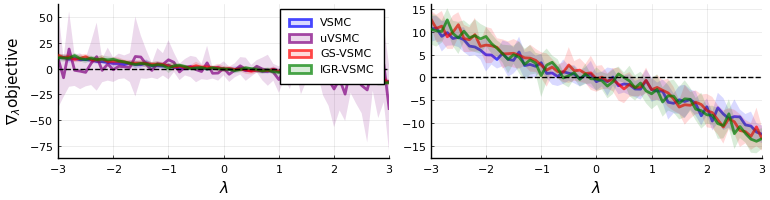

In [9]:
λs = -3:0.1:3 # Values of λ to estimate gradient at
samples = 10  # Number of samples to take at each value of λ

pyplot(size=(770,200))

# Get mean and variance of the gradient estimates
∇_means_vsmc, ∇_vars_vsmc = estimate_var(λs, ∇SLGSS_obj_vsmc, samples=samples)
∇_means_uvsmc, ∇_vars_uvsmc = estimate_var(λs, ∇SLGSS_obj_uvsmc, samples=samples)
∇_means_gs, ∇_vars_gs = estimate_var(λs, ∇SLGSS_obj_gs, samples=samples)
∇_means_igr, ∇_vars_igr = estimate_var(λs, ∇SLGSS_obj_igr, samples=samples)

# Plot mean and variance
pvar1 = plot(λs, ∇_means_vsmc, ribbon=sqrt.(∇_vars_vsmc), label=VSMC,
    xlab=L"\lambda", ylab=L"\nabla_\lambda\mathrm{objective}", xlim=(min(λs...),max(λs...)), legend=:topright,
    linecolor=VSMC_col, fillcolor=VSMC_col; LW_LO_FA...)
plot!(λs, ∇_means_uvsmc, ribbon=sqrt.(∇_vars_uvsmc), label=uVSMC, linecolor=uVSMC_col, fillcolor=uVSMC_col; LW_LO_FA...)
plot!(λs, ∇_means_gs, ribbon=sqrt.(∇_vars_gs), label=GS_VSMC, linecolor=GS_VSMC_col, fillcolor=GS_VSMC_col; LW_LO_FA...)
plot!(λs, ∇_means_igr, ribbon=sqrt.(∇_vars_igr), label=IGR_VSMC, linecolor=IGR_VSMC_col, fillcolor=IGR_VSMC_col; LW_LO_FA...)
hline!([0], linecolor=:black, linestyle=:dash, label=nothing)

pvar2 = plot(λs, ∇_means_vsmc, ribbon=sqrt.(∇_vars_vsmc),
    xlab=L"\lambda", xlim=xlims(pvar1), legend=nothing, linecolor=VSMC_col, fillcolor=VSMC_col; LW_LO_FA...)
plot!(λs, ∇_means_gs, ribbon=sqrt.(∇_vars_gs), linecolor=GS_VSMC_col, fillcolor=GS_VSMC_col; LW_LO_FA...)
plot!(λs, ∇_means_igr, ribbon=sqrt.(∇_vars_igr), linecolor=IGR_VSMC_col, fillcolor=IGR_VSMC_col; LW_LO_FA...)
hline!([0], linecolor=:black, linestyle=:dash, label=nothing)

plot(pvar1, pvar2)

In [10]:
if save_figures
    png("grad_est_var")
end

#### 2.2.2. ELBO estimation
Experiment 2: evaluate how well the methods can estimate the ELBO with different step sequences

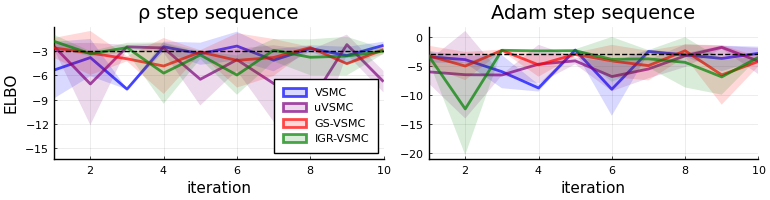

In [11]:
iters = 10 # Number of GD iterations
runs = 2   # Number of runs per method

pyplot(size=(770,200))

# Get mean and variance of ELBO estimates using the ρ step sequence
obj_mean_vsmc, obj_var_vsmc = plot_gd_helper(SLGSS_obj_vsmc, ∇SLGSS_obj_vsmc, λ, iters, runs)
obj_mean_uvsmc, obj_var_uvsmc = plot_gd_helper(SLGSS_obj_uvsmc, ∇SLGSS_obj_uvsmc, λ, iters, runs)
obj_mean_gs, obj_var_gs = plot_gd_helper(SLGSS_obj_gs, ∇SLGSS_obj_gs, λ, iters, runs)
obj_mean_igr, obj_var_igr = plot_gd_helper(SLGSS_obj_igr, ∇SLGSS_obj_igr, λ, iters, runs)

# Plot mean and variance
pelbo1 = plot(1:iters, obj_mean_vsmc, ribbon=sqrt.(obj_var_vsmc), label=VSMC, legend=:bottomright,
    xlab="iteration", ylab="ELBO", title="ρ step sequence", xlim=(1,iters), linecolor=VSMC_col, fillcolor=VSMC_col; LW_LO_FA...)
plot!(1:iters, obj_mean_uvsmc, ribbon=sqrt.(obj_var_uvsmc), label=uVSMC, linecolor=uVSMC_col, fillcolor=uVSMC_col; LW_LO_FA...)
plot!(1:iters, obj_mean_gs, ribbon=sqrt.(obj_var_gs), label=GS_VSMC, linecolor=GS_VSMC_col, fillcolor=GS_VSMC_col; LW_LO_FA...)
plot!(1:iters, obj_mean_igr, ribbon=sqrt.(obj_var_igr), label=IGR_VSMC, linecolor=IGR_VSMC_col, fillcolor=IGR_VSMC_col; LW_LO_FA...)
hline!([log_marginal], linecolor=:black, linestyle=:dash, label=nothing)

# Get mean and variance of ELBO estimates using the Adam step sequence
obj_mean_vsmc, obj_var_vsmc = plot_gd_helper(SLGSS_obj_vsmc, ∇SLGSS_obj_vsmc, λ, iters, runs, step=ADAM)
obj_mean_uvsmc, obj_var_uvsmc = plot_gd_helper(SLGSS_obj_uvsmc, ∇SLGSS_obj_uvsmc, λ, iters, runs, step=ADAM)
obj_mean_gs, obj_var_gs = plot_gd_helper(SLGSS_obj_gs, ∇SLGSS_obj_gs, λ, iters, runs, step=ADAM)
obj_mean_igr, obj_var_igr = plot_gd_helper(SLGSS_obj_igr, ∇SLGSS_obj_igr, λ, iters, runs, step=ADAM)

# Plot mean and variance
pelbo2 = plot(1:iters, obj_mean_vsmc, ribbon=sqrt.(obj_var_vsmc), legend=nothing,
    xlab="iteration", title="Adam step sequence", xlim=(1,iters), linecolor=VSMC_col, fillcolor=VSMC_col; LW_LO_FA...)
plot!(1:iters, obj_mean_uvsmc, ribbon=sqrt.(obj_var_uvsmc), linecolor=uVSMC_col, fillcolor=uVSMC_col; LW_LO_FA...)
plot!(1:iters, obj_mean_gs, ribbon=sqrt.(obj_var_gs), linecolor=GS_VSMC_col, fillcolor=GS_VSMC_col; LW_LO_FA...)
plot!(1:iters, obj_mean_igr, ribbon=sqrt.(obj_var_igr), linecolor=IGR_VSMC_col, fillcolor=IGR_VSMC_col; LW_LO_FA...)
hline!([log_marginal], linecolor=:black, linestyle=:dash, label=nothing)

plot(pelbo1, pelbo2)

In [12]:
if save_figures
    png("slgss_elbo")
end

### 2.3. SLGSS experiment - setting 2
$T=4$

Experiment 3: evaluate effect of temperature $\tau$

In [13]:
# Initialize SMC parameters
dimX = 1
dimY = 1
T = 4
N = 2
slgssτ_smc = SMC(dimX, dimY, T, N, SLGSS_sim_prop, SLGSS_log_weights, SLGSS_log_prop)

# Initialize model params
model_params = SLGSS_init_model_params()

# Generate data
x_true, y_true = SLGSS_generate_data(model_params, T)

# True log marginal likelihood
log_marginal = log_marginal_likelihood(model_params, T, y_true, dimX)

# τ values to evaluate
τ1 = 10.
τ2 = 0.1
τ3 = 0.001

# Create closures of objective and gradient function
SLGSS_obj_gs1 = λ -> SLGSS_obj(λ, model_params, y_true, slgssτ_smc, method=GS_VSMC, τ=τ1)
SLGSS_obj_gs2 = λ -> SLGSS_obj(λ, model_params, y_true, slgssτ_smc, method=GS_VSMC, τ=τ2)
SLGSS_obj_gs3 = λ -> SLGSS_obj(λ, model_params, y_true, slgssτ_smc, method=GS_VSMC, τ=τ3)

∇SLGSS_obj_gs1 = λ -> ∇SLGSS_obj(λ, model_params, y_true, slgssτ_smc, method=GS_VSMC, τ=τ1)
∇SLGSS_obj_gs2 = λ -> ∇SLGSS_obj(λ, model_params, y_true, slgssτ_smc, method=GS_VSMC, τ=τ2)
∇SLGSS_obj_gs3 = λ -> ∇SLGSS_obj(λ, model_params, y_true, slgssτ_smc, method=GS_VSMC, τ=τ3)

pyplot(size=(770,200))

Plots.PyPlotBackend()

Check $\tau$ effect on variance of gradient estimator

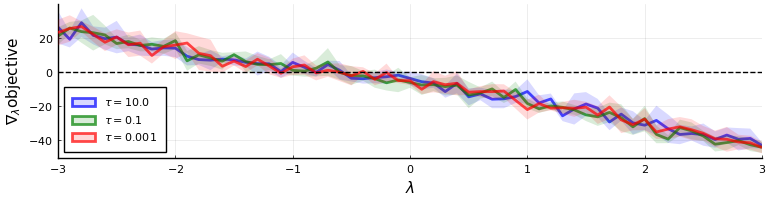

In [14]:
λs = -3:0.1:3 # λ values to estimate gradient at
samples = 5   # Number of samples to take at each value of λ

# Estimate mean and variance of gradient estimates
∇_means_gs1, ∇_vars_gs1 = estimate_var(λs, ∇SLGSS_obj_gs1, samples=samples)
∇_means_gs2, ∇_vars_gs2 = estimate_var(λs, ∇SLGSS_obj_gs2, samples=samples)
∇_means_gs3, ∇_vars_gs3 = estimate_var(λs, ∇SLGSS_obj_gs3, samples=samples)

# Plot mean and variance
pvarτ = plot(λs, ∇_means_gs1, ribbon=sqrt.(∇_vars_gs1), label=L"\tau=%$τ1",
    xlab=L"\lambda", ylab=L"\nabla_\lambda\mathrm{objective}", xlim=(min(λs...),max(λs...)), legend=:bottomleft,
    linecolor=VSMC_col, fillcolor=VSMC_col; LW_LO_FA...)
plot!(λs, ∇_means_gs2, ribbon=sqrt.(∇_vars_gs2), label=L"\tau=%$τ2", linecolor=:green, fillcolor=:green; LW_LO_FA...)
plot!(λs, ∇_means_gs3, ribbon=sqrt.(∇_vars_gs3), label=L"\tau=%$τ3", linecolor=GS_VSMC_col, fillcolor=GS_VSMC_col; LW_LO_FA...)
hline!([0], linecolor=:black, linestyle=:dash, label=nothing)

Check $\tau$ effect on ELBO estimation when $N=2$ and when $N=50$

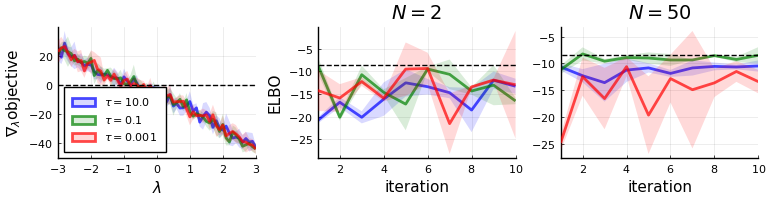

In [15]:
λ = [1.]   # Initial variational parameter value
iters = 10 # Number of GD iterations
runs = 2   # Number of runs for each method

# Estimate mean and variance of ELBO estimates
obj_mean_gs1, obj_var_gs1 = plot_gd_helper(SLGSS_obj_gs1, ∇SLGSS_obj_gs1, λ, iters, runs)
obj_mean_gs2, obj_var_gs2 = plot_gd_helper(SLGSS_obj_gs2, ∇SLGSS_obj_gs2, λ, iters, runs)
obj_mean_gs3, obj_var_gs3 = plot_gd_helper(SLGSS_obj_gs3, ∇SLGSS_obj_gs3, λ, iters, runs)

# Plot mean and variance
pelboτ1 = plot(1:iters, obj_mean_gs1, ribbon=sqrt.(obj_var_gs1), legend=nothing,
    xlab="iteration", ylab="ELBO", title=L"N=2", xlim=(1,iters), linecolor=VSMC_col, fillcolor=VSMC_col; LW_LO_FA...)
plot!(1:iters, obj_mean_gs2, ribbon=sqrt.(obj_var_gs2), linecolor=:green, fillcolor=:green; LW_LO_FA...)
plot!(1:iters, obj_mean_gs3, ribbon=sqrt.(obj_var_gs3), linecolor=GS_VSMC_col, fillcolor=GS_VSMC_col; LW_LO_FA...)
hline!([log_marginal], linecolor=:black, linestyle=:dash, label=nothing)


# Check effect on ELBO estimation when N = 50
slgssτ_smc50 = SMC(dimX, dimY, T, 50, SLGSS_sim_prop, SLGSS_log_weights, SLGSS_log_prop)

SLGSS_obj_gs1 = λ -> SLGSS_obj(λ,model_params,y_true,slgssτ_smc50,method=GS_VSMC,τ=τ1)
SLGSS_obj_gs2 = λ -> SLGSS_obj(λ,model_params,y_true,slgssτ_smc50,method=GS_VSMC,τ=τ2)
SLGSS_obj_gs001 = λ -> SLGSS_obj(λ,model_params,y_true,slgssτ_smc50,method=GS_VSMC,τ=τ3)

∇SLGSS_obj_gs1 = λ -> ∇SLGSS_obj(λ,model_params,y_true,slgssτ_smc50,method=GS_VSMC,τ=τ1)
∇SLGSS_obj_gs2 = λ -> ∇SLGSS_obj(λ,model_params,y_true,slgssτ_smc50,method=GS_VSMC,τ=τ2)
∇SLGSS_obj_gs001 = λ -> ∇SLGSS_obj(λ,model_params,y_true,slgssτ_smc50,method=GS_VSMC,τ=τ3)

# Estimate mean and variance of ELBO estimates
obj_mean_gs1, obj_var_gs1 = plot_gd_helper(SLGSS_obj_gs1, ∇SLGSS_obj_gs1, λ, iters, runs)
obj_mean_gs2, obj_var_gs2 = plot_gd_helper(SLGSS_obj_gs2, ∇SLGSS_obj_gs2, λ, iters, runs)
obj_mean_gs3, obj_var_gs3 = plot_gd_helper(SLGSS_obj_gs3, ∇SLGSS_obj_gs3, λ, iters, runs)

pelboτ2 = plot(1:iters, obj_mean_gs1, ribbon=sqrt.(obj_var_gs1),
    xlab="iteration", title=L"N=50", xlim=(1,iters), legend=nothing, linecolor=VSMC_col, fillcolor=VSMC_col; LW_LO_FA...)
plot!(1:iters, obj_mean_gs2, ribbon=sqrt.(obj_var_gs2), linecolor=:green, fillcolor=:green; LW_LO_FA...)
plot!(1:iters, obj_mean_gs3, ribbon=sqrt.(obj_var_gs3), linecolor=GS_VSMC_col, fillcolor=GS_VSMC_col; LW_LO_FA...)
hline!([log_marginal], linecolor=:black, linestyle=:dash, label=nothing)

plot(pvarτ, pelboτ1, pelboτ2, layout=(1,3))

In [16]:
if save_figures
    png("tau_plots")
end

# 3. Linear Gaussian state space model

### 3.1. LGSS specific functions

In [17]:
# Initializes LGSS model parameters
function LGSS_init_model_params(dimX, dimY, α, r)
    # α: positive real
    # r: positive real
    # output: tuple of LGSS model parameters
    μ0 = zeros(dimX)
    Σ0 = Matrix{Float64}(I, dimX, dimX)
    
    A = zeros(dimX, dimX)
    for i in 1:dimX
        for j in 1:dimX
            A[i,j] = α^(abs(i-j)+1)
        end
    end
    Q = Matrix{Float64}(I, dimX, dimX)
    C = randn(dimY, dimX)
    R = r * Matrix{Float64}(I,dimY,dimY)
    
    return μ0, Σ0, A, Q, C, R
end


# Initializes LGSS proposal parameters
function LGSS_init_prop_params(T, dimX, scale)
    # scale: positive real
    # output: list of LGSS proposal parameters
    return [(scale * randn(dimX),     # Bias
            0.5 .+ scale*randn(dimX), # Linear times A/μ0
            scale * randn(dimX))      # Log variance
            for t in 1:T]
end


# Generates LGSS data
function LGSS_generate_data(model_params, T)
    # output: sequences x and y of length T
    μ0, Σ0, A, Q, C, R = model_params
    
    dimX = size(μ0)[1]
    dimY = size(R)[1]
    
    x_true = zeros(T, dimX)
    y_true = zeros(T, dimY)
    for t in 1:T
        # Generate x_t
        if t > 1
            x_dist = MvNormal(A*x_true[t-1,:], Q)
        else
            x_dist = MvNormal(μ0, Σ0)
        end
        x_true[t,:] = rand(x_dist, 1)
        # Generate y_t
        y_dist = MvNormal(C*x_true[t,:], R)
        y_true[t,:] = rand(y_dist ,1)
    end
    return x_true, y_true
end


# Samples from the proposal distribution
function LGSS_sim_prop(t, X_anc, y, prop_params, model_params)
    # X_anc: ancestor states to condition on
    # output: [N,dimX] matrix of proposed states
    
    # Extract parameters
    μ0, Σ0, A, Q, C, R = model_params
    N, dimX = size(X_anc)
    μt, lint, log_σ2t = prop_params[t]
    σt = sqrt.(exp.(log_σ2t))
    
    # Propose
    if t > 1
        μ = μt' .+ (A*X_anc')'.* lint'
    else
        μ = (μt + lint.*μ0)'
    end
    return μ .+ randn(N,dimX) .* σt'
end


# Computes the log probability of the proposal
function LGSS_log_prop(t, X, X_anc, y, prop_params, model_params)
    # X: state values to evaluate
    # X_anc: ancestor states to condition on
    # output: log proposal probabilities of X given X_anc
    
    # Extract parameters
    μ0, Σ0, A, Q, C, R = model_params
    μt, lint, log_σ2t = prop_params[t]
    σ2t = exp.(log_σ2t)
    dimX = length(σ2t)
    
    if t > 1
        μ = μt' .+ (A*X_anc')'.* lint'
    else
        μ = μt + lint.*μ0
    end
    return log_normal(X, μ, σ2t.*Matrix{Float64}(I,dimX,dimX))
end


# Computes the log weights
function LGSS_log_weights(t, X, X_anc, y, prop_params, model_params)
    # X: state values to weight
    # X_anc: ancestor states that are conditioned on
    return log_target(t,X,X_anc,y,model_params) - LGSS_log_prop(t,X,X_anc,y,prop_params,model_params)
end


# Helper function to flatten parameters for AutoGrad
function LGSS_flatten_params(prop_params, T, dimX)
    # output: vector of all parameters to optimize
    dimλ = 3*T*dimX
    flat_params = zeros(dimλ)
    k = 3*dimX
    for i in 1:T
        flat_params[(1+k*(i-1)):(k+k*(i-1))] .= (prop_params[i][1]...,prop_params[i][2]...,prop_params[i][3]...)
    end
    return flat_params, dimλ
end

# Helper function to reshape flattened parameters
function LGSS_unflatten_params(flat_params, T, dimX)
    # output: list of parameters in their original shape
    k = 3*dimX
    return [(flat_params[(1+k*(i-1)):(dimX+k*(i-1))],
             flat_params[(1+dimX+k*(i-1)):(2*dimX+k*(i-1))],
             flat_params[(1+2*dimX+k*(i-1)):(k+k*(i-1))]) for i in 1:T]
end


# LGSS objective
function LGSS_obj(flat_λ, model_params, y, smc, unflatten_f; method=VSMC, τ=0.05, return_ess=false)
    # flat_λ: flattened parameters to optimize
    # unflatten_f: function to unflatten the parameters
    # other inputs: see vsmc_lower_bound
    # output: ELBO estimate
    λ = unflatten_f(flat_λ)
    return vsmc_lower_bound(λ, model_params, y, smc, method=method, τ=τ, return_ess=return_ess)
end

# Gradient of LGSS objective
function ∇LGSS_obj(flat_λ, model_params, y, smc, unflatten_f; method=VSMC, τ=0.05)
    # flat_λ: flattened parameters to optimize
    # unflatten_f: function to unflatten the parameters
    # other inputs: see vsmc_lower_bound
    # output: gradient of ELBO objective
    if method == uVSMC
        ∇flat_λ = ∇vsmc_lower_bound(flat_λ, model_params, y, smc, unflatten_f=unflatten_f)
    elseif method == IGR_VSMC
        # Using ForwardDiff because AutoGrad cannot handle diff-within-diff
        ∇flat_λ = ForwardDiff.gradient(flat_λ->LGSS_obj(flat_λ,model_params,y,smc,method=method,τ=τ), flat_λ)
    else
        grad_f = grad(LGSS_obj)
        ∇flat_λ = grad_f(flat_λ, model_params, y, smc, unflatten_f, method=method, τ=τ)
    end
    return ∇flat_λ
end

∇LGSS_obj (generic function with 1 method)

### 3.1. LGSS ELBO estimation - setting 1
$\dim(X) = 10$, $\dim(Y)=3$

In [18]:
# Initialize SMC object
dimX = 10
dimY = 3
T = 10
N = 4
lgss_smc = SMC(dimX, dimY, T, N, LGSS_sim_prop, LGSS_log_weights, LGSS_log_prop)

# Initialize model and data parameters
α = 0.42
r = 1
model_params = LGSS_init_model_params(dimX, dimY, α, r)

# Generate data
x_true, y_true = LGSS_generate_data(model_params, T)

# Compute the log marginal likelihood
log_marginal = log_marginal_likelihood(model_params, T, y_true, dimX)

# Initialize the proposal parameters
param_scale = 0.5
prop_params = LGSS_init_prop_params(T, dimX, param_scale)

flat_params, dimλ = LGSS_flatten_params(prop_params, T, dimX)
unflatten_f = flat_params -> LGSS_unflatten_params(flat_params, T, dimX)

# Create closures of objective and gradient function
LGSS_obj_vsmc = λ -> LGSS_obj(λ, model_params, y_true, lgss_smc, unflatten_f, method=VSMC)
LGSS_obj_uvsmc = λ -> LGSS_obj(λ, model_params, y_true, lgss_smc, unflatten_f, method=uVSMC)
LGSS_obj_gs = λ -> LGSS_obj(λ, model_params, y_true, lgss_smc, unflatten_f, method=GS_VSMC)
LGSS_obj_igr = λ -> LGSS_obj(λ, model_params, y_true, lgss_smc, unflatten_f, method=IGR_VSMC)

∇LGSS_obj_vsmc = λ -> ∇LGSS_obj(λ, model_params, y_true, lgss_smc, unflatten_f, method=VSMC)
∇LGSS_obj_uvsmc = λ -> ∇LGSS_obj(λ, model_params, y_true, lgss_smc, unflatten_f, method=uVSMC)
∇LGSS_obj_gs = λ -> ∇LGSS_obj(λ, model_params, y_true, lgss_smc, unflatten_f, method=GS_VSMC)
∇LGSS_obj_igr = λ -> ∇LGSS_obj(λ, model_params, y_true, lgss_smc, unflatten_f, method=IGR_VSMC)

#96 (generic function with 1 method)

Experiment 4: evaluate how well the methods estimate the ELBO in LGSS when $\dim(X)=10$, $\dim(Y)=3$

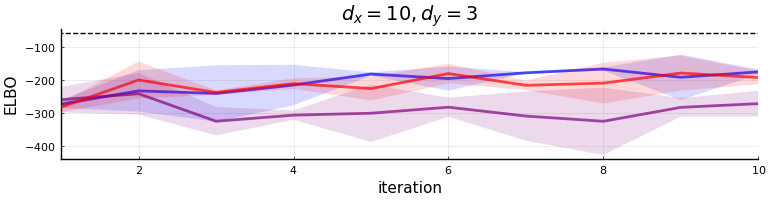

In [19]:
iters = 10 # Number of GD iterations
runs = 2   # Number of runs per method

pyplot(size=(770,200))

# Estimate the mean and variance of the ELBO estimate
# Note: Adam step sequence seems to help uVSMC a bit
# Note: IGR was too slow in this context
obj_mean_vsmc, obj_var_vsmc = plot_gd_helper(LGSS_obj_vsmc, ∇LGSS_obj_vsmc, flat_params, iters, runs)
obj_mean_uvsmc, obj_var_uvsmc = plot_gd_helper(LGSS_obj_uvsmc, ∇LGSS_obj_uvsmc, flat_params, iters, runs, step=ADAM)
obj_mean_gs, obj_var_gs = plot_gd_helper(LGSS_obj_gs, ∇LGSS_obj_gs, flat_params, iters, runs)

# Plot the mean and variance
pelbo3 = plot(1:iters, obj_mean_vsmc, ribbon=sqrt.(obj_var_vsmc), legend=nothing,
    xlab="iteration", ylab="ELBO", title=L"d_x=%$dimX,d_y=%$dimY", xlim=(1,iters),
    linecolor=VSMC_col, fillcolor=VSMC_col; LW_LO_FA...)
plot!(1:iters, obj_mean_uvsmc, ribbon=sqrt.(obj_var_uvsmc), linecolor=uVSMC_col, fillcolor=uVSMC_col; LW_LO_FA...)
plot!(1:iters, obj_mean_gs, ribbon=sqrt.(obj_var_gs), linecolor=GS_VSMC_col, fillcolor=GS_VSMC_col; LW_LO_FA...)
hline!([log_marginal], linecolor=:black, linestyle=:dash, label=nothing)

### 3.2. LGSS ELBO estimation - setting 2
$\dim(X) = 25$, $\dim(Y)=1$

In [20]:
# Initialize SMC object
dimX = 25
dimY = 1
T = 10
N = 4
lgss_smc = SMC(dimX, dimY, T, N, LGSS_sim_prop, LGSS_log_weights, LGSS_log_prop)

# Initialize model and data parameters
α = 0.42
r = 1
model_params = LGSS_init_model_params(dimX, dimY, α, r)

# Generate data
x_true, y_true = LGSS_generate_data(model_params, T)

# Compute the log marginal likelihood
log_marginal = log_marginal_likelihood(model_params, T, y_true, dimX)

# Initialize the proposal parameters
param_scale = 0.5
prop_params = LGSS_init_prop_params(T, dimX, param_scale)

flat_params, dimλ = LGSS_flatten_params(prop_params, T, dimX)
unflatten_f = flat_params -> LGSS_unflatten_params(flat_params, T, dimX)

# Create closures of objective and gradient function
LGSS_obj_vsmc = λ -> LGSS_obj(λ, model_params, y_true, lgss_smc, unflatten_f, method=VSMC)
LGSS_obj_uvsmc = λ -> LGSS_obj(λ, model_params, y_true, lgss_smc, unflatten_f, method=uVSMC)
LGSS_obj_gs = λ -> LGSS_obj(λ, model_params, y_true, lgss_smc, unflatten_f, method=GS_VSMC)
LGSS_obj_igr = λ -> LGSS_obj(λ, model_params, y_true, lgss_smc, unflatten_f, method=IGR_VSMC)

∇LGSS_obj_vsmc = λ -> ∇LGSS_obj(λ, model_params, y_true, lgss_smc, unflatten_f, method=VSMC)
∇LGSS_obj_uvsmc = λ -> ∇LGSS_obj(λ, model_params, y_true, lgss_smc, unflatten_f, method=uVSMC)
∇LGSS_obj_gs = λ -> ∇LGSS_obj(λ, model_params, y_true, lgss_smc, unflatten_f, method=GS_VSMC)
∇LGSS_obj_igr = λ -> ∇LGSS_obj(λ, model_params, y_true, lgss_smc, unflatten_f, method=IGR_VSMC)

#114 (generic function with 1 method)

Experiment 5: evaluate how well the methods estimate the ELBO in LGSS when $\dim(X)=25$, $\dim(Y)=1$

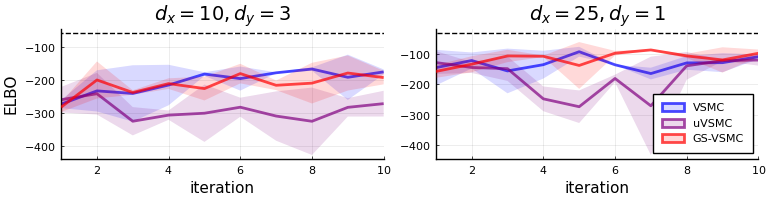

In [21]:
iters = 10 # Number of GD iterations
runs = 2   # Number of runs per method

# Estimate the mean and variance of the ELBO estimate
# Note: Adam step sequence seems to help uVSMC a bit
# Note: IGR was too slow in this context
obj_mean_vsmc, obj_var_vsmc = plot_gd_helper(LGSS_obj_vsmc, ∇LGSS_obj_vsmc, flat_params, iters, runs)
obj_mean_uvsmc, obj_var_uvsmc = plot_gd_helper(LGSS_obj_uvsmc, ∇LGSS_obj_uvsmc, flat_params, iters, runs, step=ADAM)
obj_mean_gs, obj_var_gs = plot_gd_helper(LGSS_obj_gs, ∇LGSS_obj_gs, flat_params, iters, runs)

# Plot the mean and variance
pelbo4 = plot(1:iters, obj_mean_vsmc, ribbon=sqrt.(obj_var_vsmc), label=VSMC, legend=:bottomright,
    xlab="iteration", title=L"d_x=%$dimX, d_y=%$dimY", xlim=(1,iters), linecolor=VSMC_col, fillcolor=VSMC_col; LW_LO_FA...)
plot!(1:iters, obj_mean_uvsmc, ribbon=sqrt.(obj_var_uvsmc), label=uVSMC, linecolor=uVSMC_col, fillcolor=uVSMC_col; LW_LO_FA...)
plot!(1:iters, obj_mean_gs, ribbon=sqrt.(obj_var_gs), label=GS_VSMC, linecolor=GS_VSMC_col, fillcolor=GS_VSMC_col; LW_LO_FA...)
hline!([log_marginal], linecolor=:black, linestyle=:dash, label=nothing)

plot(pelbo3, pelbo4)

In [22]:
if save_figures
    png("lgss_elbo")
end

# 4. Capital Asset Pricing Model

### 4.1. CAPM specific functions

In [23]:
# Initialize CAPM model parameters
function CAPM_init_model_params()
    # output: tuple of CAPM model parameters
    μ0 = 0
    Σ0 = 1
    A = 0.5
    Q = 1
    C = 1
    R = 1
    return μ0, Σ0, A, Q, C, R
end


# Computes the log probability of the proposal
function CAPM_log_prop(t, X, X_anc, y, prop_params, model_params)
    # X: state values to evaluate
    # X_anc: ancestor states to condition on
    # output: log proposal probabilities of X given X_anc
    λ = prop_params
    μ = λ .+ 0.5*X_anc
    return log_normal(X, μ, 1)
end


# Computes the log probability of the joint model
function CAPM_log_target(t, X, X_anc, y, model_params)
    # X: state values to evaluate
    # X_anc: ancestor states to condition on
    # output: log probabilities under the joint model
    μ0, Σ0, A, Q, C, R = model_params
    
    log_trans = log_normal(X,(A*X_anc')', Q)
    if t > 1
        log_trans = log_normal(X,(A*X_anc')', Q)
    else
        log_trans = log_normal(X, μ0, Σ0)
    end
    log_obs = log_normal((C*X')', y[t], R)
    return log_trans + log_obs
end


# Computes the log weights
function CAPM_log_weights(t, X, X_anc, y, prop_params, model_params)
    # X: state values to weight
    # X_anc: ancestor states that are conditioned on
    # output: log weights for X
    return CAPM_log_target(t,X,X_anc,y,model_params) - CAPM_log_prop(t,X,X_anc,y,prop_params,model_params)
end


# Samples from the proposal
function CAPM_sim_prop(t, X_anc, y, prop_params, model_params)
    # X_anc: ancestor states to condition on
    # output: N samples from the proposal
    λ = prop_params
    N = size(X_anc)[1]
    μ = λ .+ 0.5*X_anc
    return μ + randn(N)
end


# CAPM objective
function CAPM_obj(combined_params, y, smc; method=VSMC, τ=0.05, return_ess=false)
    # combined_params: vector of model and proposal parameters
    # method: one of {VSMC, GS_VSMC, IGR_VSMC}
    # output: ELBO estimate
    model_params = combined_params[1:6]
    λ = combined_params[7]
    return vsmc_lower_bound(λ, model_params, y, smc, method=method, τ=τ, return_ess=return_ess)
end

# Gradient of CAPM objective
function ∇CAPM_obj(combined_params, y, smc; method=VSMC, τ=0.05)
    # combined_params: vector of model and proposal parameters
    # method: one of {VSMC, GS_VSMC, IGR_VSMC}
    # output: gradient of CAPM objective
    if method == IGR_VSMC
        # Using ForwardDiff because AutoGrad cannot handle diff-within-diff
        ∇params = ForwardDiff.gradient(p->CAPM_obj(p,y,smc,method=method,τ=τ), combined_params)
    else
        grad_f = grad(CAPM_obj)
        ∇params = grad_f(combined_params, y, smc, method=method, τ=τ)
    end
    return ∇params
end

∇CAPM_obj (generic function with 1 method)

### 4.2. Modeling the CAPM dataset

In [24]:
# Extract and view the dataset
Capm = dataset("Ecdat", "Capm")
first(Capm,5)

,RFood,RDur,RCon,RMRF,RF
,Float64,Float64,Float64,Float64,Float64
1,-4.59,0.87,-6.84,-6.99,0.33
2,2.62,3.46,2.78,0.99,0.29
3,-1.67,-2.28,-0.48,-1.46,0.35
4,0.86,2.41,-2.02,-1.7,0.19
5,7.34,6.33,3.69,3.08,0.27


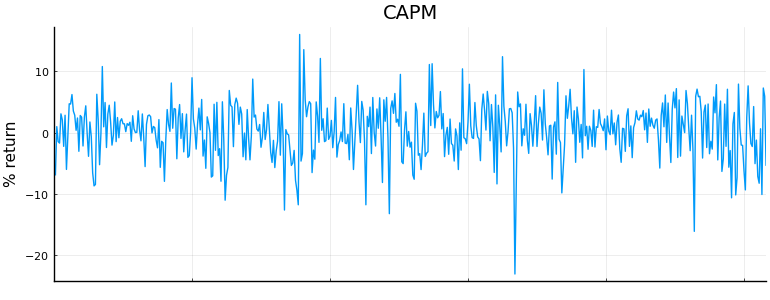

In [25]:
# Extract the RMRF column
T = nrow(Capm)
y_true = Capm."RMRF"

# Plot the data
pyplot(size=(770,300))
xticks = (0:100:500,["","","","","",""])
yticks = (-20:10:10,["","","",""])
pcapm = plot(1:T, y_true, title="CAPM", ylab="% return", legend=nothing, xlims=(0,T), xticks=xticks)

In [26]:
# Initialize SMC object
dimX = 1
dimY = 1
N = 8
capm_smc = SMC(dimX, dimY, T, N, CAPM_sim_prop, CAPM_log_weights, CAPM_log_prop)

# Initialize the model and proposal parameters
model_params = CAPM_init_model_params()
λ = 1.
combined_params = [model_params...; λ]

# Create closures of objective and gradient function
CAPM_obj_vsmc = p -> CAPM_obj(p, y_true, capm_smc, method=VSMC)
CAPM_obj_gs = p -> CAPM_obj(p, y_true, capm_smc, method=GS_VSMC)
CAPM_obj_igr = p -> CAPM_obj(p, y_true, capm_smc, method=IGR_VSMC)

∇CAPM_obj_vsmc = p -> ∇CAPM_obj(p, y_true, capm_smc, method=VSMC)
∇CAPM_obj_gs = p -> ∇CAPM_obj(p, y_true, capm_smc, method=GS_VSMC)
∇CAPM_obj_igr = p -> ∇CAPM_obj(p, y_true, capm_smc, method=IGR_VSMC)

#130 (generic function with 1 method)

Experiment 5: evaluate the methods for modeling the CAPM dataset

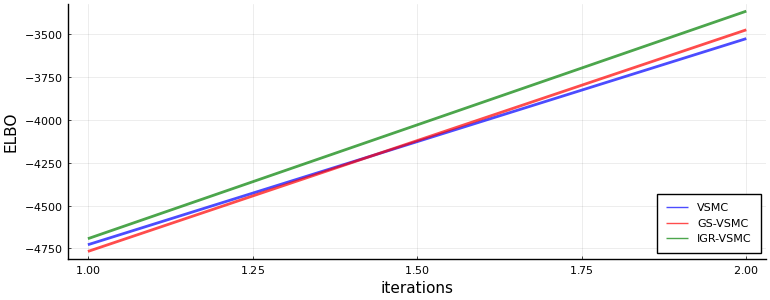

In [27]:
iters = 2 # Number of GD iterations to run

# Learn the model and proposal parameters through variational expectation-maximization
params_vsmc, elbo_vsmc = gradient_descent(CAPM_obj_vsmc, ∇CAPM_obj_vsmc, combined_params; iters=iters)
params_gs, elbo_gs = gradient_descent(CAPM_obj_gs, ∇CAPM_obj_gs, combined_params; iters=iters)
params_igr, elbo_igr = gradient_descent(CAPM_obj_igr, ∇CAPM_obj_igr, combined_params; iters=iters)

# Collect the learned parameters
final_params_vsmc = params_vsmc[iters,:]
final_params_gs = params_gs[iters,:]
final_params_igr = params_igr[iters,:]

# Plot the ELBO
pelbocapm = plot(1:iters, elbo_vsmc, label=VSMC, legend=:bottomright,
    ylab="ELBO", xlab="iterations", linecolor=VSMC_col; LW_LO_FA...)
plot!(1:iters, elbo_gs, label=GS_VSMC, linecolor=GS_VSMC_col; LW_LO_FA...)
plot!(1:iters, elbo_igr, label=IGR_VSMC, linecolor=IGR_VSMC_col; LW_LO_FA...)

Estimate the mean and standard deviation of the normalized ESS for each method

In [28]:
n = 100 # Number of ESS samples

# Compute normalized ESS
ess_vsmc = zeros(n)
ess_gs = zeros(n)
ess_igr = zeros(n)

for i in 1:n
    logZ, ess = CAPM_obj(final_params_vsmc, y_true, capm_smc, return_ess=true)
    ess_vsmc[i] = ess
    
    logZ, ess = CAPM_obj(final_params_gs, y_true, capm_smc, return_ess=true)
    ess_gs[i] = ess
    
    logZ, ess = CAPM_obj(final_params_igr, y_true, capm_smc, return_ess=true)
    ess_igr[i] = ess
end

println("VSMC ESS: ", mean(ess_vsmc), " ± ", std(ess_vsmc))
println("GS-VSMC ESS: ", mean(ess_gs), " ± ", std(ess_gs))
println("IGR-VSMC ESS: ", mean(ess_igr), " ± ", std(ess_igr))

VSMC ESS: 0.16499804548203034 ± 0.056550539763408125
GS-VSMC ESS: 0.1716337757529474 ± 0.06132625972861651
IGR-VSMC ESS: 0.17876765208508114 ± 0.07323985101563228


Generate a $y_{1:T}$ sample from each method

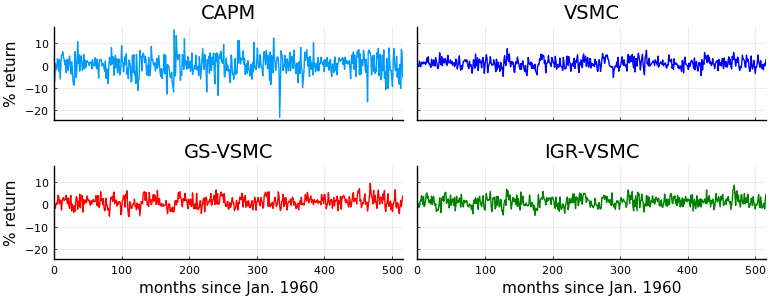

In [29]:
# Generate observation samples using the learned parameters
# C = final_params[5], R = final_params[6]
sample_x_vsmc = sim_q(final_params_vsmc[7], final_params_vsmc[1:6], y_true, capm_smc)[1,:,1]
sample_y_vsmc = final_params_vsmc[5] .* sample_x_vsmc + sqrt(final_params_vsmc[6]) .* randn(T)

sample_x_gs = sim_q(final_params_gs[7], final_params_gs[1:6], y_true, capm_smc)[1,:,1]
sample_y_gs = final_params_gs[5] .* sample_x_gs + sqrt(final_params_gs[6]) .* randn(T)

sample_x_igr = sim_q(final_params_igr[7], final_params_igr[1:6], y_true, capm_smc)[1,:,1]
sample_y_igr = final_params_igr[5] .* sample_x_gs + sqrt(final_params_igr[6]) .* randn(T)

# Plot the samples and compare it to the original data
pcapm_vsmc = plot(1:T, sample_y_vsmc, legend=nothing, linecolor=VSMC_col,
    title="VSMC", xlims=xlims(pcapm), ylims=ylims(pcapm), xticks=xticks, yticks=yticks)
pcapm_gs = plot(1:T, sample_y_gs, legend=nothing, linecolor=GS_VSMC_col,
    title="GS-VSMC", xlab="months since Jan. 1960", ylab="% return", xlims=xlims(pcapm), ylims=ylims(pcapm))
pcapm_igr = plot(1:T,sample_y_igr, legend=nothing, linecolor=IGR_VSMC_col,
    title="IGR-VSMC", xlab="months since Jan. 1960", xlims=xlims(pcapm), ylims=ylims(pcapm), yticks=yticks)

pcapmss = plot(pcapm, pcapm_vsmc, pcapm_gs, pcapm_igr)

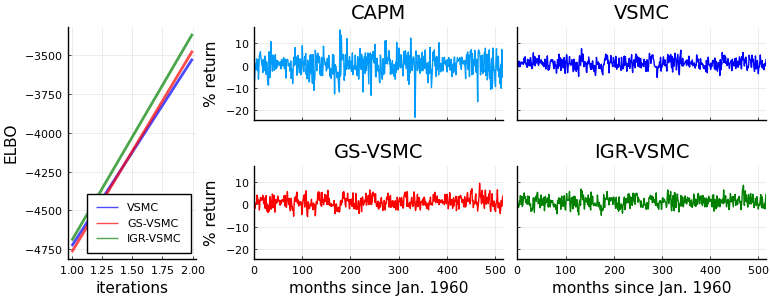

In [30]:
l = @layout[a{0.2w} b{0.8w}]
plot(pelbocapm, pcapmss, layout=l)

In [31]:
if save_figures
    png("capm_plots")
end